In [1]:
import nd
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np

In [2]:
plt.rcParams['figure.figsize'] = (12, 8)

# Reading data

For this example we are using a subset of the GHRSST sea surface temperature data set
(https://www.ghrsst.org/ghrsst-data-services/products/).

The provided subset contains the monthly mean temperature in the region of the gulf stream for the year 2019.

We can read the NetCDF file using `xarray` and convert the temperature to degrees Celsius:

In [3]:
ds = xr.open_dataset('ghrsst_gulf_2019.nc')
sst_celsius = ds['analysed_sst'] - 273.15

We can create a simple visualization of the data for January using built-in plotting methods in `xarray`:

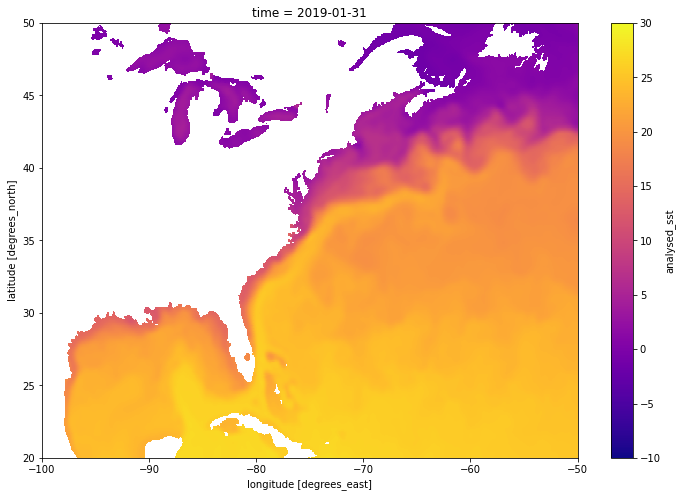

In [4]:
sst_celsius.isel(time=0).plot(cmap='plasma', vmin=-10, vmax=30);

---

# Visualization

We will now be looking at more advanced visualization methods using the `nd` library.
In this example, we are going to create a video from the time series data.

In [5]:
mask = (ds['mask'] != 2).any('time')
sst_celsius.nd.to_video('sst.gif', fps=6, fontcolor=(255, 255, 255), cmap='plasma', mask=mask, width=600)

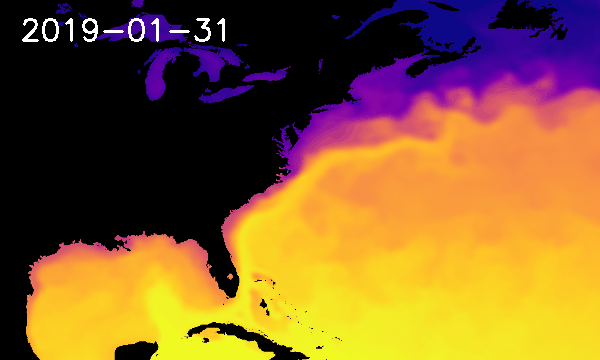

In [6]:
from IPython.display import Image
Image(filename="sst.gif")

# Classification

We will now demonstrate how to use `scikit-learn` classifiers with `xarray` data sets,
with the help of an `nd.classify.Classifier`.

As we have no labels for our data, we are going to do a simple clustering using KMeans.

In [7]:
from sklearn.cluster import KMeans
import nd.classify

As we want the clustering to be time invariant we need to specify that 'time' is a feature dimension.
This means that the full time series will be used to derive the clusters, rather than considering each time step individually.

In [8]:
clf = nd.classify.Classifier(
    KMeans(n_clusters=3),
    feature_dims=['time']
)

In [9]:
clf = clf.fit(sst_celsius)

In [10]:
pred = clf.predict(sst_celsius).transpose('y', 'x')

We can visualize the clustering result by color coding the cluster labels:

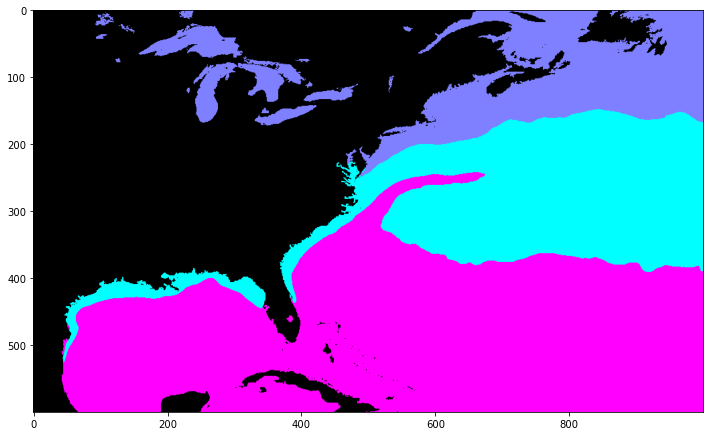

In [11]:
im = pred.nd.to_rgb(cmap='cool', mask=~pred.isnull())
plt.imshow(im);

# Reprojection

The library makes it easy to reproject an entire xarray data set to a new coordinate reference system. `rasterio` is used in the backend.

In [12]:
ds_proj = ds.nd.reproject(src_crs='epsg:4326', dst_crs='epsg:2163')

The following shows a slice of the original data (in EPSG:4326) alongside the reprojected data set (EPSG:2163).

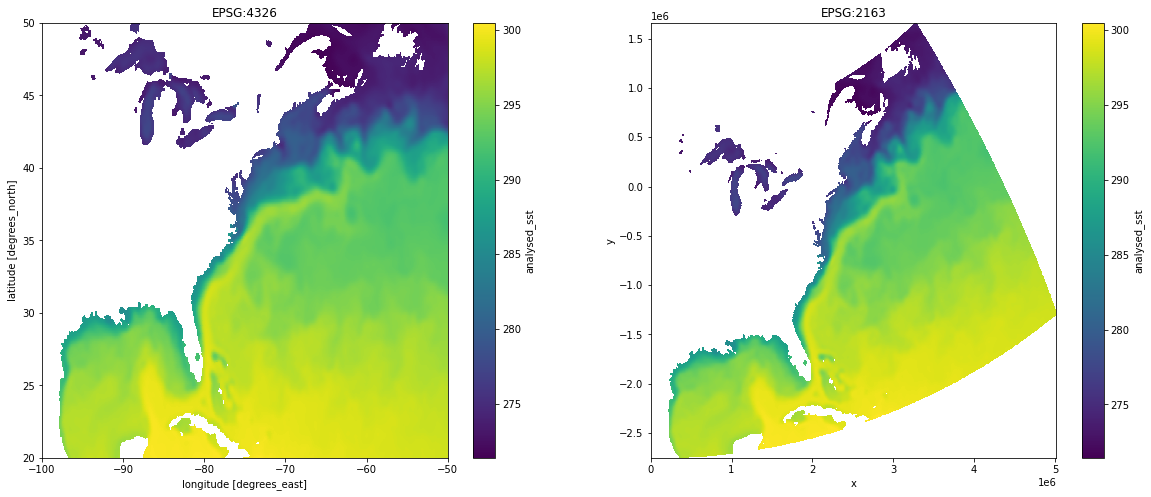

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(20, 8))
ds['analysed_sst'].isel(time=0).plot(ax=ax[0])
ax[0].set_title('EPSG:4326')
ds_proj['analysed_sst'].isel(time=0).plot(ax=ax[1])
ax[1].set_title('EPSG:2163');